# Load and Configuration

In [ ]:
#@title Load Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)

import os
import re

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [2]:
files = [file for file in os.listdir() if file.endswith('.csv')]

df_movies = pd.read_csv(files[0])
df_tv = pd.read_csv(files[1])

print("Sample Movie Data:")
display(df_movies[:3])

print("Sample TV Data:")
display(df_tv[:3])

Sample Movie Data:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue
0,10192,Movie,Shrek Forever After,Mike Mitchell,"Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...",United States of America,2010-05-16,2010,6.380,NaN,"Comedy, Adventure, Fantasy, Animation, Family",en,A bored and domesticated Shrek pacts with deal...,203.893,7449,6.380,165000000,752600867
1,27205,Movie,Inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","United Kingdom, United States of America",2010-07-15,2010,8.369,NaN,"Action, Science Fiction, Adventure",en,"Cobb, a skilled thief who commits corporate es...",156.242,37119,8.369,160000000,839030630
2,12444,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...","United Kingdom, United States of America",2010-11-17,2010,7.744,NaN,"Adventure, Fantasy",en,"Harry, Ron and Hermione walk away from their l...",121.191,19327,7.744,250000000,954305868


Sample TV Data:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average
0,33238,TV Show,Running Man,안재철,"Yoo Jae-suk, Jee Seok-jin, Kim Jong-kook, Haha...",South Korea,2010-07-11,2010,8.241,1 Seasons,"Comedy, Reality",ko,A reality and competition show where members a...,1929.898,187,8.241
1,32415,TV Show,Conan,NaN,"Conan O'Brien, Andy Richter",United States of America,2010-11-08,2010,7.035,1 Seasons,"Talk, Comedy, News",en,A late night television talk show hosted by C...,1670.580,229,7.035
2,37757,TV Show,MasterChef Greece,NaN,NaN,Greece,2010-10-03,2010,5.600,1 Seasons,Reality,el,MasterChef Greece is a Greek competitive cooki...,1317.092,6,5.600


# Data & Exploration 

**Dataset Overview**
- Movies — 16,000 rows × 18 columns. 
- TV Shows — 16,000 rows × 16 columns. 
- Both span 2010–2025, with 397 overlapping `show_id`.  

**Key Features for recommendation**
- Content feature: genres (multi-label, comma-separated), description (text), language (74 for movies, diverse for TV), cast, director, country
- Engagement signals: `popularity`, `vote_count`, `vote_average`
- Movie-only extras: `budget` and `revenue` (not appear in tv)

**Data Quality**
- Movie data fairly cleaned except all `duration` contain null and float value, minor gap in `director`/`cast`/`country`
- TV data have more gap (i.e., `director` is 69% null, `description` is 20% null, and `genres` has ~6% missing)
- In TV data, `duration` is in "X season" format
- `date_added` is string both movie and TV
- Genre taxonomies differ between the two datasets (e.g., movies use "Science Fiction" vs TV uses "Sci-Fi & Fantasy"; movies use "Action" vs TV uses "Action & Adventure")

In [3]:
def df_summary(df, name="DataFrame"):
    summary = {
        "Year Range": f"{df.release_year.min()} - {df.release_year.max()}",
        "Shape": df.shape,
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Columns Name": list(df.columns),
        "Memory": f"{df.memory_usage(deep=True).sum() / 1024:.1f} KB",
        "Data Types": df.dtypes.value_counts(),
        "List of Dtype": df.dtypes,
        "Null Counts": df.isna().sum()[df.isna().sum() > 0],
        "Genres": df.genres.dropna().head(10).to_list(),
        "Language unique": df.language.nunique(),
        "Rating stat": df.vote_average.describe().round(2)
    }
    print(f"{name.upper()} OVERVIEW")
    print("-" * 40)
    for key, value in summary.items():
        print(f"{key}:\n{value}\n")

df_summary(df_movies,"Movies")
print("="*100+"\n")
df_summary(df_tv, "TV show")

MOVIES OVERVIEW
----------------------------------------
Year Range:
2010 - 2025

Shape:
(16000, 18)

Rows:
16000

Columns:
18

Columns Name:
['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'genres', 'language', 'description', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']

Memory:
17112.8 KB

Data Types:
object     9
int64      5
float64    4
Name: count, dtype: int64

List of Dtype:
show_id           int64
type             object
title            object
director         object
cast             object
country          object
date_added       object
release_year      int64
rating          float64
duration        float64
genres           object
language         object
description      object
popularity      float64
vote_count        int64
vote_average    float64
budget            int64
revenue           int64
dtype: object

Null Counts:
director         132
cast             204
country          466
duratio

In [4]:
#@title Compare schemas side by side

movie_cols = set(df_movies.columns)
tv_cols = set(df_tv.columns)

print("\nCompare both column")
print("-"*50)
print("Columns ONLY in Movies:", movie_cols - tv_cols)
print("Columns ONLY in TV:", tv_cols - movie_cols)
print("Shared Columns:", movie_cols & tv_cols)


Compare both column
--------------------------------------------------
Columns ONLY in Movies: {'budget', 'revenue'}
Columns ONLY in TV: set()
Shared Columns: {'show_id', 'country', 'cast', 'type', 'vote_average', 'title', 'director', 'release_year', 'language', 'vote_count', 'rating', 'duration', 'description', 'genres', 'date_added', 'popularity'}


In [5]:
#@title Check null count and percentage

print("=== MOVIES - Missing Values ===")
movie_nulls = df_movies.isnull().sum()
movie_nulls_pct = (movie_nulls / len(df_movies) * 100).round(2)
print(pd.DataFrame({'count': movie_nulls, 'pct': movie_nulls_pct})[movie_nulls > 0])

print("\n=== TV SHOWS - Missing Values ===")
tv_nulls = df_tv.isnull().sum()
tv_nulls_pct = (tv_nulls / len(df_tv) * 100).round(2)
print(pd.DataFrame({'count': tv_nulls, 'pct': tv_nulls_pct})[tv_nulls > 0])

=== MOVIES - Missing Values ===
             count     pct
director       132    0.82
cast           204    1.27
country        466    2.91
duration     16000  100.00
genres         107    0.67
description    132    0.82

=== TV SHOWS - Missing Values ===
             count    pct
director     10965  68.53
cast          1157   7.23
country       1797  11.23
genres         974   6.09
description   3206  20.04


ID OVERLAP ANALYSIS
----------------------------------------
Movies: 16,000
TV: 15,991
Overlapping: 397

SAMPLE OVERLAPPING RECORDS (n=5)
----------------------------------------

show_id: 63498
  df1: [['Chico & Rita', 'Movie', 'Animation, Music, Romance']]
  df2: [['Close Up with The Hollywood Reporter', 'TV Show', 'Talk']]

show_id: 59429
  df1: [['Paranormal Activity: Tokyo Night', 'Movie', 'Horror, Thriller']]
  df2: [['Lucky Fred', 'TV Show', 'Animation, Action & Adventure, Comedy, Family, Kids, Sci-Fi & Fantasy']]

show_id: 45094
  df1: [['Conviction', 'Movie', 'Drama']]
  df2: [['The Following', 'TV Show', 'Crime, Drama']]

show_id: 55341
  df1: [['Jeepers Creepers 3', 'Movie', 'Horror, Mystery, Thriller']]
  df2: [["Nature's Weirdest Events", 'TV Show', 'Documentary, Family']]

show_id: 282672
  df1: [['My Mistress', 'Movie', 'Romance, Drama']]
  df2: [['EXchange-Another Beginning', 'TV Show', 'Reality']]


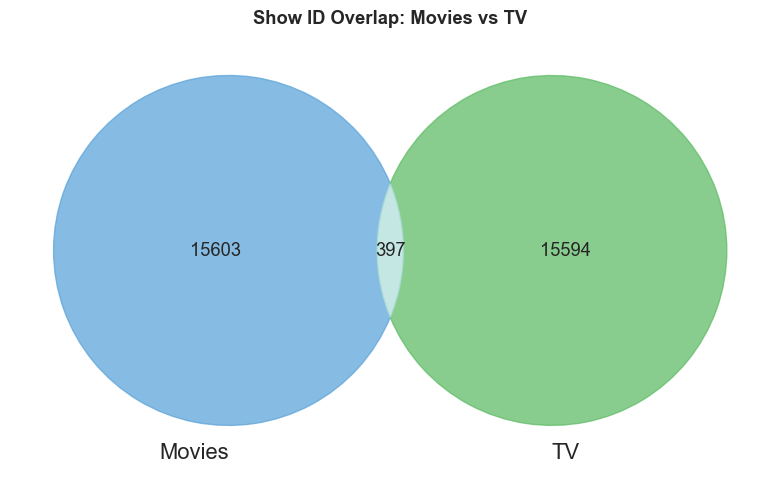

In [6]:
#@title Check show_id overlap

def check_id_overlap(df1, df2, id_col='show_id', name1='Movies', name2='TV'):
    ids1 = set(df1[id_col])
    ids2 = set(df2[id_col])
    overlap = ids1 & ids2
    
    print("ID OVERLAP ANALYSIS")
    print("-" * 40)
    print(f"{name1}: {len(ids1):,}")
    print(f"{name2}: {len(ids2):,}")
    print(f"Overlapping: {len(overlap):,}")
    
    return overlap


def show_overlap_samples(df1, df2, overlap_ids, id_col='show_id', cols=['title', 'type', 'genres'], n=5):
    print(f"\nSAMPLE OVERLAPPING RECORDS (n={n})")
    print("-" * 40)
    
    for sid in list(overlap_ids)[:n]:
        print(f"\nshow_id: {sid}")
        print(f"  df1: {df1[df1[id_col] == sid][cols].values.tolist()}")
        print(f"  df2: {df2[df2[id_col] == sid][cols].values.tolist()}")


def plot_id_overlap(df1, df2, id_col='show_id', name1='Movies', name2='TV'):
    ids1 = set(df1[id_col])
    ids2 = set(df2[id_col])

    fig, ax = plt.subplots(figsize=(8, 6))
    v = venn2([ids1, ids2], set_labels=(name1, name2), ax=ax)

    v.get_patch_by_id('10').set_color('#5DA5DA')
    v.get_patch_by_id('01').set_color('#60BD68')
    v.get_patch_by_id('11').set_color('#B2DFDB')

    for patch_id in ['10', '01', '11']:
        v.get_patch_by_id(patch_id).set_alpha(0.75)

    ax.set_title('Show ID Overlap: Movies vs TV', fontweight='bold')
    plt.tight_layout()
    plt.show()

overlap = check_id_overlap(df_movies, df_tv)
show_overlap_samples(df_movies, df_tv, overlap)
plot_id_overlap(df_movies, df_tv)

Unique movie cast: 35250
Unique TV cast: 34046
Shared cast members: 9586

Sample shared cast: ['Mustafa Shakir', 'Lawrence Kao', 'Lili Taylor', 'Greg Bryk', 'Kenny Doughty', 'Adam Faison', 'Hilary Rose', 'Josh Brener', 'Teruyuki Kagawa', 'Sean Keenan']

Unique movie directors: 10183
Unique TV directors: 4348
Shared directors: 502


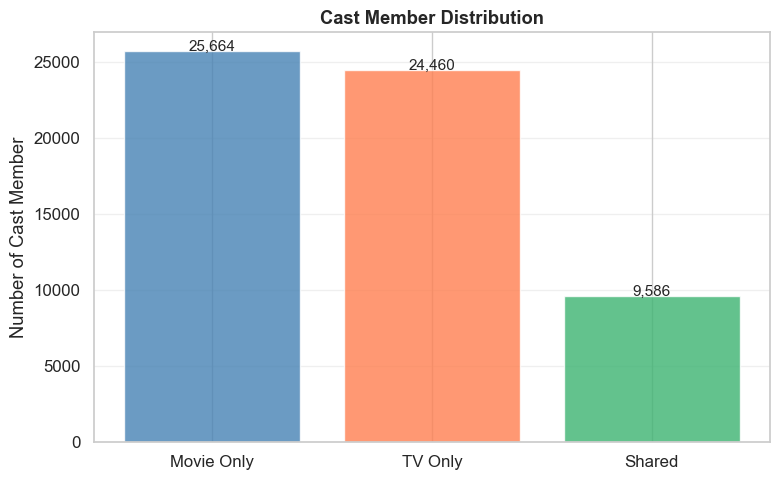

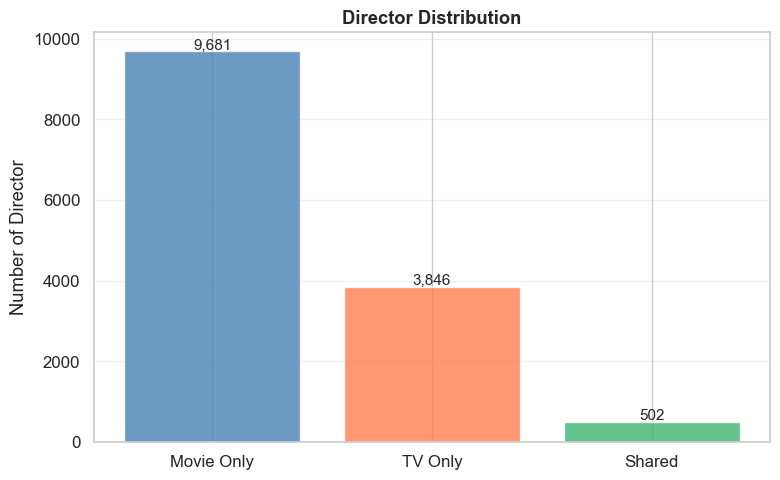

In [7]:
#@title Shared cast member/director across movie and TV

def extract_names(series):
    names = set()
    for val in series.dropna():
        for name in val.split(','):
            names.add(name.strip())
    return names

def plot_comparison(movie, tv, name="Cast Member"):
    shared = movie & tv
    movie_only = movie - tv
    tv_only = tv - movie

    categories = ['Movie Only', 'TV Only', 'Shared']
    counts = [len(movie_only), len(tv_only), len(shared)]
    colors = ['steelblue', 'coral', 'mediumseagreen']

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(categories, counts, color=colors, alpha=0.8)

    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count:,}', ha='center', fontsize=11)

    ax.set_ylabel(f'Number of {name}')
    ax.set_title(f'{name} Distribution', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

movie_cast = extract_names(df_movies['cast'])
tv_cast = extract_names(df_tv['cast'])

movie_directors = extract_names(df_movies['director'])
tv_directors = extract_names(df_tv['director'])

shared_cast = movie_cast & tv_cast
shared_directors = movie_directors & tv_directors

print(f"Unique movie cast: {len(movie_cast)}")
print(f"Unique TV cast: {len(tv_cast)}")
print(f"Shared cast members: {len(shared_cast)}")
print(f"\nSample shared cast: {list(shared_cast)[:10]}")

print(f"\nUnique movie directors: {len(movie_directors)}")
print(f"Unique TV directors: {len(tv_directors)}")
print(f"Shared directors: {len(shared_directors)}")

plot_comparison(movie_cast, tv_cast)
plot_comparison(movie_directors, tv_directors, name="Director")

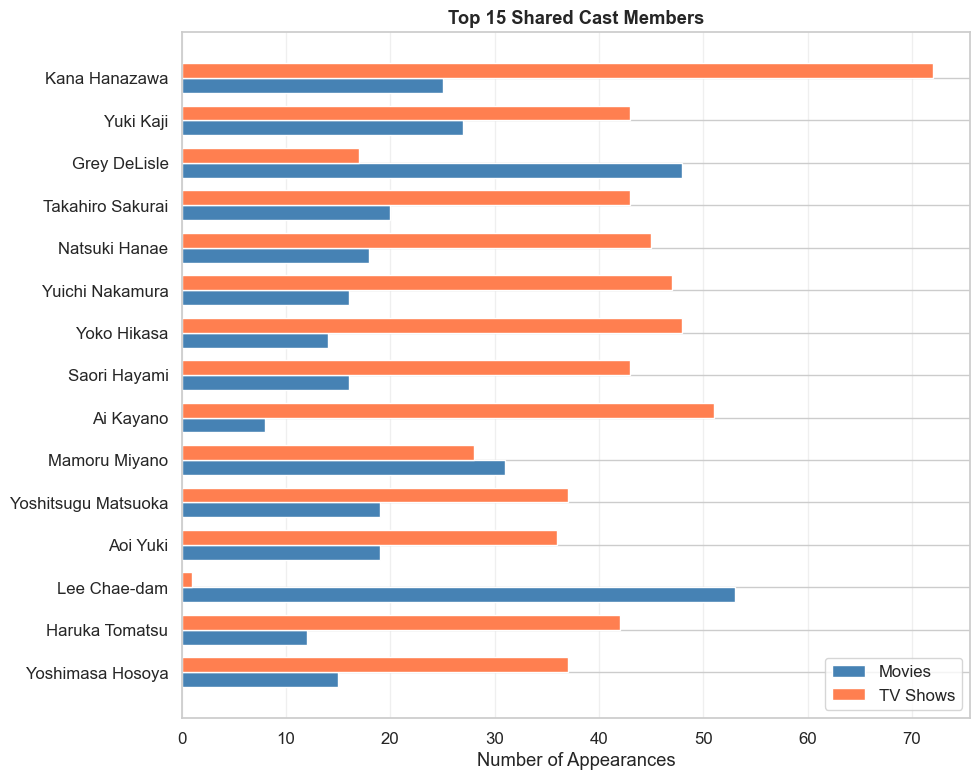

In [8]:
def count_appearances(df, cast_set):
    counts = Counter()
    for val in df['cast'].dropna():
        for name in val.split(','):
            name = name.strip()
            if name in cast_set:
                counts[name] += 1
    return counts

def plot_top_shared_cast(df_movies, df_tv, shared_cast, top_n=15):
    movie_counts = count_appearances(df_movies, shared_cast)
    tv_counts = count_appearances(df_tv, shared_cast)

    total_counts = {name: movie_counts.get(name, 0) + tv_counts.get(name, 0)
                    for name in shared_cast}
    top_cast = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    names = [x[0] for x in top_cast][::-1]
    movies = [movie_counts.get(n, 0) for n in names]
    tv = [tv_counts.get(n, 0) for n in names]

    y = np.arange(len(names))
    height = 0.35

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(y - height/2, movies, height, label='Movies', color='steelblue')
    ax.barh(y + height/2, tv, height, label='TV Shows', color='coral')

    ax.set_yticks(y)
    ax.set_yticklabels(names)
    ax.set_xlabel('Number of Appearances')
    ax.set_title(f'Top {top_n} Shared Cast Members', fontweight='bold')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_top_shared_cast(df_movies, df_tv, shared_cast)

Movies — 'genres'
Null count: 107
Items per entry — min: 1, max: 8, mean: 2.4, median: 2

TV Shows — 'genres'
Null count: 974
Items per entry — min: 1, max: 7, mean: 1.9, median: 2



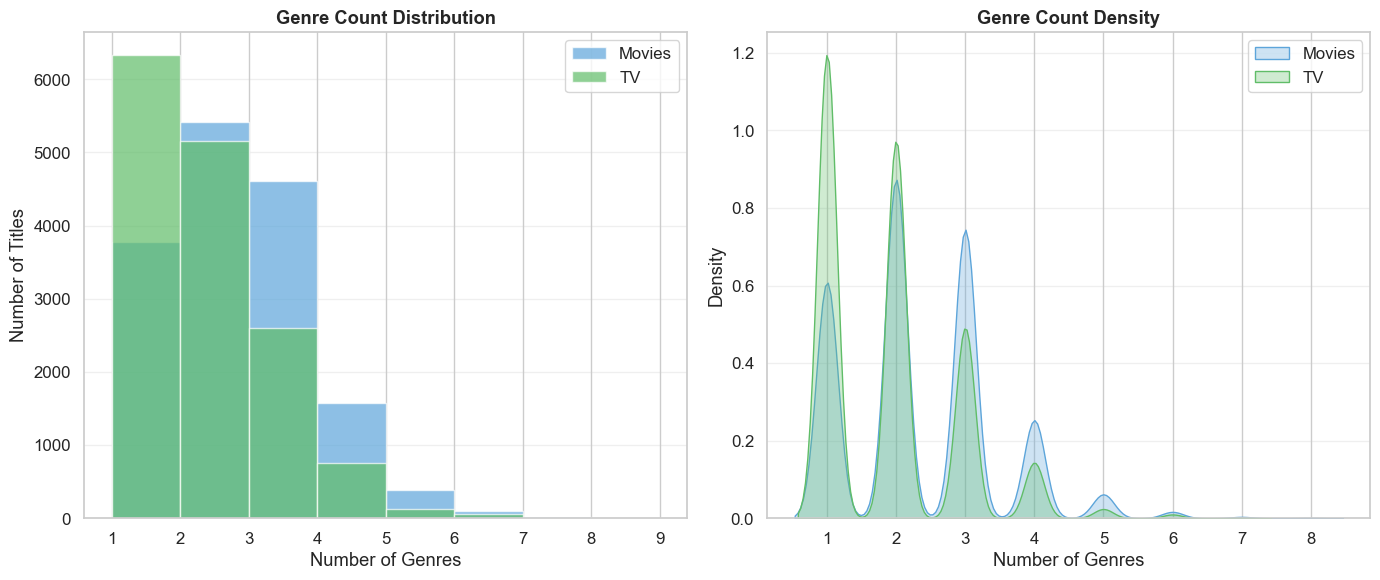

In [52]:
# Genre structure
def analyze_multi_value(df, column, label):
    counts = df[column].dropna().apply(lambda x: len(x.split(',')))
    print(f"{label} — '{column}'")
    print(f"Null count: {df[column].isnull().sum()}")
    print(f"Items per entry — min: {counts.min()}, max: {counts.max()}, "
          f"mean: {counts.mean():.1f}, median: {counts.median():.0f}")
    print()

def plot_genre_count_distribution(df_movies, df_tv):
    movie_counts = df_movies['genres'].dropna().apply(lambda x: len(x.split(',')))
    tv_counts = df_tv['genres'].dropna().apply(lambda x: len(x.split(',')))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram
    axes[0].hist(movie_counts, bins=range(1, movie_counts.max() + 2),
                 alpha=0.7, label='Movies', color='#5DA5DA', edgecolor='white')
    axes[0].hist(tv_counts, bins=range(1, tv_counts.max() + 2),
                 alpha=0.7, label='TV', color='#60BD68', edgecolor='white')
    axes[0].set_xlabel('Number of Genres')
    axes[0].set_ylabel('Number of Titles')
    axes[0].set_title('Genre Count Distribution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # KDE
    sns.kdeplot(movie_counts, label='Movies', color='#5DA5DA',
                fill=True, alpha=0.3, ax=axes[1])
    sns.kdeplot(tv_counts, label='TV', color='#60BD68',
                fill=True, alpha=0.3, ax=axes[1])
    axes[1].set_xlabel('Number of Genres')
    axes[1].set_title('Genre Count Density', fontweight='bold')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

analyze_multi_value(df_movies, 'genres', 'Movies')
analyze_multi_value(df_tv, 'genres', 'TV Shows')
plot_genre_count_distribution(df_movies, df_tv)

In [11]:
#Get all unique genres from each dataset
def get_unique_values(df, column):
    values = set()
    for val in df[column].dropna():
        for item in val.split(','):
            values.add(item.strip())
    return sorted(values)

movie_genres = get_unique_values(df_movies, 'genres')
tv_genres = get_unique_values(df_tv, 'genres')

print(f"Movie genres ({len(movie_genres)}):\n{movie_genres}\n")
print(f"TV genres ({len(tv_genres)}):\n{tv_genres}\n")

print(f"Shared genres: {sorted(set(movie_genres) & set(tv_genres))}")
print(f"Movie-only genres: {sorted(set(movie_genres) - set(tv_genres))}")
print(f"TV-only genres: {sorted(set(tv_genres) - set(movie_genres))}")

Movie genres (19):
['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']

TV genres (17):
['Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Kids', 'Mystery', 'News', 'Reality', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics', 'Western']

Shared genres: ['Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Mystery', 'Western']
Movie-only genres: ['Action', 'Adventure', 'Fantasy', 'History', 'Horror', 'Music', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War']
TV-only genres: ['Action & Adventure', 'Kids', 'News', 'Reality', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics']


       vote_average  vote_count  popularity
count      16000.00    16000.00    16000.00
mean           5.96      718.66       20.38
std            1.75     2080.20       68.61
min            0.00        0.00        3.86
25%            5.60       53.00        7.84
50%            6.30      138.00       10.91
75%            6.92      422.00       17.34
max           10.00    37119.00     3876.01

       vote_average  vote_count  popularity
count      16000.00    16000.00    16000.00
mean           5.42      107.01       64.85
std            3.27      607.46      139.39
min            0.00        0.00        2.32
25%            2.70        1.00       24.87
50%            6.80        4.00       36.19
75%            7.80       30.00       62.19
max           10.00    24664.00     6421.92


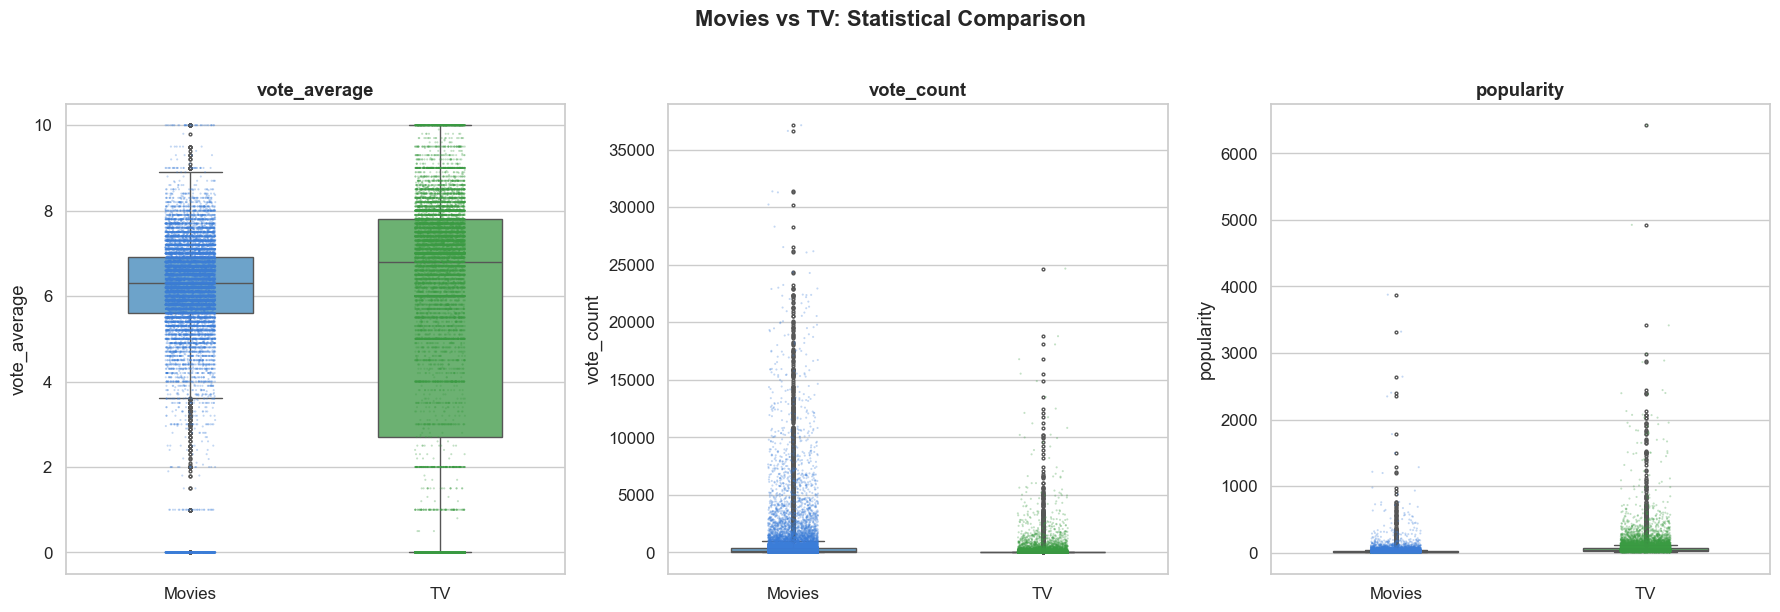


Movies vote_avg where vote_count=0: [0.]
TV vote_avg where vote_count=0: [ 0.  3.  8. 10.  6.  7.  9.  1.]


In [12]:
def plot_stat_comparison(df_movies, df_tv, cols=['vote_average', 'vote_count', 'popularity']):
    movies = df_movies[cols].copy()
    movies['source'] = 'Movies'
    tv = df_tv[cols].copy()
    tv['source'] = 'TV'
    combined = pd.concat([movies, tv], ignore_index=True)

    fig, axes = plt.subplots(1, len(cols), figsize=(6 * len(cols),6))

    for ax, col in zip(axes, cols):
        sns.boxplot(data=combined, x='source', y=col, hue='source',
                    palette={'Movies': '#5DA5DA', 'TV': '#60BD68'},
                    width=0.5, fliersize=2, ax=ax)
        sns.stripplot(data=combined, x='source', y=col, hue='source',
                      palette={'Movies': '#3B7DD8', 'TV': '#3A9B42'},
                      size=1.5, alpha=0.3, jitter=True, ax=ax)
        ax.set_title(col, fontweight='bold')
        ax.set_xlabel('')
        ax.get_legend()

    plt.suptitle('Movies vs TV: Statistical Comparison', fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


print(df_movies[['vote_average', 'vote_count', 'popularity']].describe().round(2))
print()
print(df_tv[['vote_average', 'vote_count', 'popularity']].describe().round(2))
plot_stat_comparison(df_movies, df_tv)
print(f"\nMovies vote_avg where vote_count=0: "
      f"{df_movies.loc[df_movies['vote_count']==0, 'vote_average'].unique()[:10]}")
print(f"TV vote_avg where vote_count=0: "
      f"{df_tv.loc[df_tv['vote_count']==0, 'vote_average'].unique()[:10]}")

In [13]:
# df_movies.loc[df_movies['vote_count']==0]
df_tv.loc[(df_tv['vote_count']==0) & (df_tv['vote_average']>0)][:5]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average
2191,59084,TV Show,Tasty Life,NaN,"Lim Chae-mu, Yoon Jung-hee, Ryu Hyun-kyung, Yo...",South Korea,2012-04-28,2012,3.0,1 Seasons,NaN,ko,Tasty Life is a 2012 South Korean television s...,71.546,0,3.0
2838,94489,TV Show,MasterChef Korea,"Kim Kwan-tae, 하정석","Hooni Kim, Song Hoon, Kim Sohyi, 김정현, 옥영민",South Korea,2012-04-27,2012,8.0,1 Seasons,Reality,ko,NaN,21.131,0,8.0
3944,100061,TV Show,Bad Obsession Motorsport - Project Binky,NaN,"Nik Blackhurst, Richard Brunning",United Kingdom,2013-08-17,2013,10.0,1 Seasons,"Reality, Documentary",en,"In the first episode of Project Binky, we take...",17.029,0,10.0
4057,91075,TV Show,Quizduell,NaN,Jörg Pilawa,Germany,2014-05-12,2014,6.0,1 Seasons,Reality,de,NaN,190.909,0,6.0
8370,234684,TV Show,西行记,Mak Ching-Lok,Beichen Liu,China,2018-07-18,2018,10.0,1 Seasons,"Animation, Drama, Action & Adventure",zh,NaN,52.946,0,10.0


In [14]:
# Missing data across content features
content_cols = ['genres', 'cast', 'director', 'description', 'language', 'country']

print("=== Missing Data (Content Features) ===\n")
for col in content_cols:
    m_null = df_movies[col].isnull().sum()
    t_null = df_tv[col].isnull().sum()
    print(f"{col:>12}  |  Movies: {m_null:>5} ({m_null/len(df_movies)*100:.1f}%)  "
          f"|  TV: {t_null:>5} ({t_null/len(df_tv)*100:.1f}%)")

=== Missing Data (Content Features) ===

      genres  |  Movies:   107 (0.7%)  |  TV:   974 (6.1%)
        cast  |  Movies:   204 (1.3%)  |  TV:  1157 (7.2%)
    director  |  Movies:   132 (0.8%)  |  TV: 10965 (68.5%)
 description  |  Movies:   132 (0.8%)  |  TV:  3206 (20.0%)
    language  |  Movies:     0 (0.0%)  |  TV:     0 (0.0%)
     country  |  Movies:   466 (2.9%)  |  TV:  1797 (11.2%)


Top 10 Languages
Movies:
 language
en    9534
fr    1054
ja     904
ko     876
es     731
zh     378
it     312
hi     290
de     279
ru     190
Name: count, dtype: int64

TV:
 language
en    4437
zh    2456
ja    1883
ko    1364
es     916
fr     585
de     451
tl     398
ar     347
pt     346
Name: count, dtype: int64


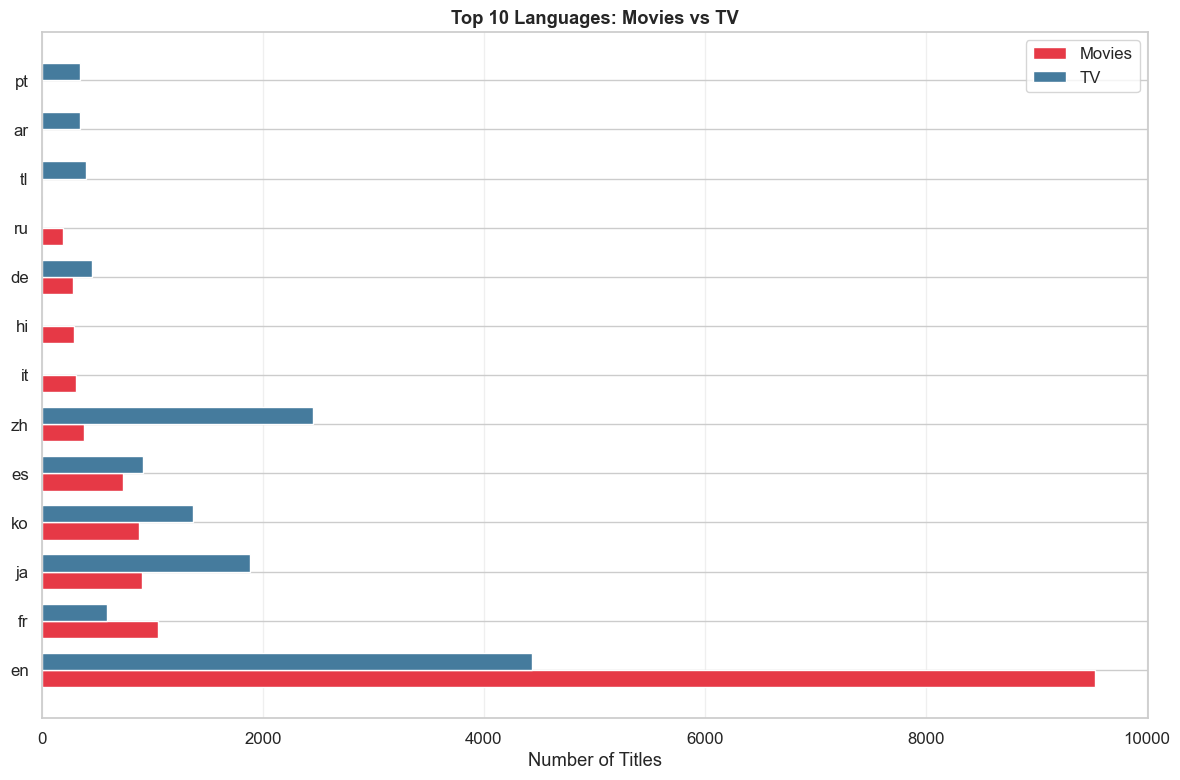


Movie languages: 74
TV languages: 71
Shared: 62


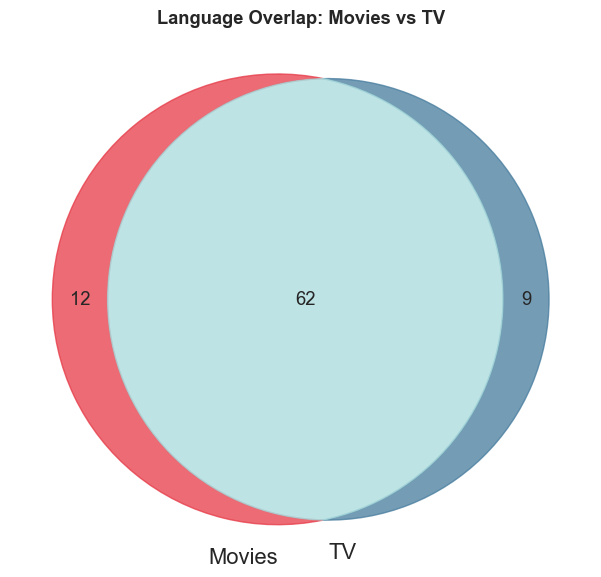

In [31]:
# Language and Country distribution

movie_lang = df_movies['language'].value_counts().head(10)
tv_lang = df_tv['language'].value_counts().head(10)

all_langs = list(dict.fromkeys(list(movie_lang.index) + list(tv_lang.index)))
movie_vals = [movie_lang.get(l, 0) for l in all_langs]
tv_vals = [tv_lang.get(l, 0) for l in all_langs]

y = np.arange(len(all_langs))
height = 0.35

print("Top 10 Languages")
print("Movies:\n", df_movies['language'].value_counts().head(10))
print("\nTV:\n", df_tv['language'].value_counts().head(10))

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y - height/2, movie_vals, height, label='Movies', color='#E63946')
ax.barh(y + height/2, tv_vals, height, label='TV', color='#457B9D')
ax.set_yticks(y)
ax.set_yticklabels(all_langs)
ax.set_xlabel('Number of Titles')
ax.set_title('Top 10 Languages: Movies vs TV', fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

m_lang = set(df_movies['language'].dropna().unique())
t_lang = set(df_tv['language'].dropna().unique())

print(f"\nMovie languages: {len(m_lang)}")
print(f"TV languages: {len(t_lang)}")
print(f"Shared: {len(m_lang & t_lang)}")

fig, ax = plt.subplots(figsize=(8, 6))
v = venn2([m_lang, t_lang], set_labels=('Movies', 'TV'), ax=ax)

for patch_id, color in [('10', '#E63946'), ('01', '#457B9D'), ('11', '#A8DADC')]:
    v.get_patch_by_id(patch_id).set_color(color)
    v.get_patch_by_id(patch_id).set_alpha(0.75)

ax.set_title('Language Overlap: Movies vs TV', fontweight='bold')
plt.tight_layout()
plt.show()

Description Length (characters)
Movies: mean=278, min=7, max=1000
TV:     mean=319, min=2, max=1790

Description example: 
["A bored and domesticated Shrek pacts with deal-maker Rumpelstiltskin to get back to feeling like a real ogre again, but when he's duped and sent to a twisted version of Far Far Away—where Rumpelstiltskin is king, ogres are hunted, and he and Fiona have never met—he sets out to restore his world and reclaim his true love.", 'Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: "inception", the implantation of another person\'s idea into a target\'s subconscious.', "Harry, Ron and Hermione walk away from their last year at Hogwarts to find and destroy the remaining Horcruxes, putting an end to Voldemort's bid for immortality. But with Harry's beloved Dumbledore dead and Voldemort's unscrupulous Death Eaters on the loose, the

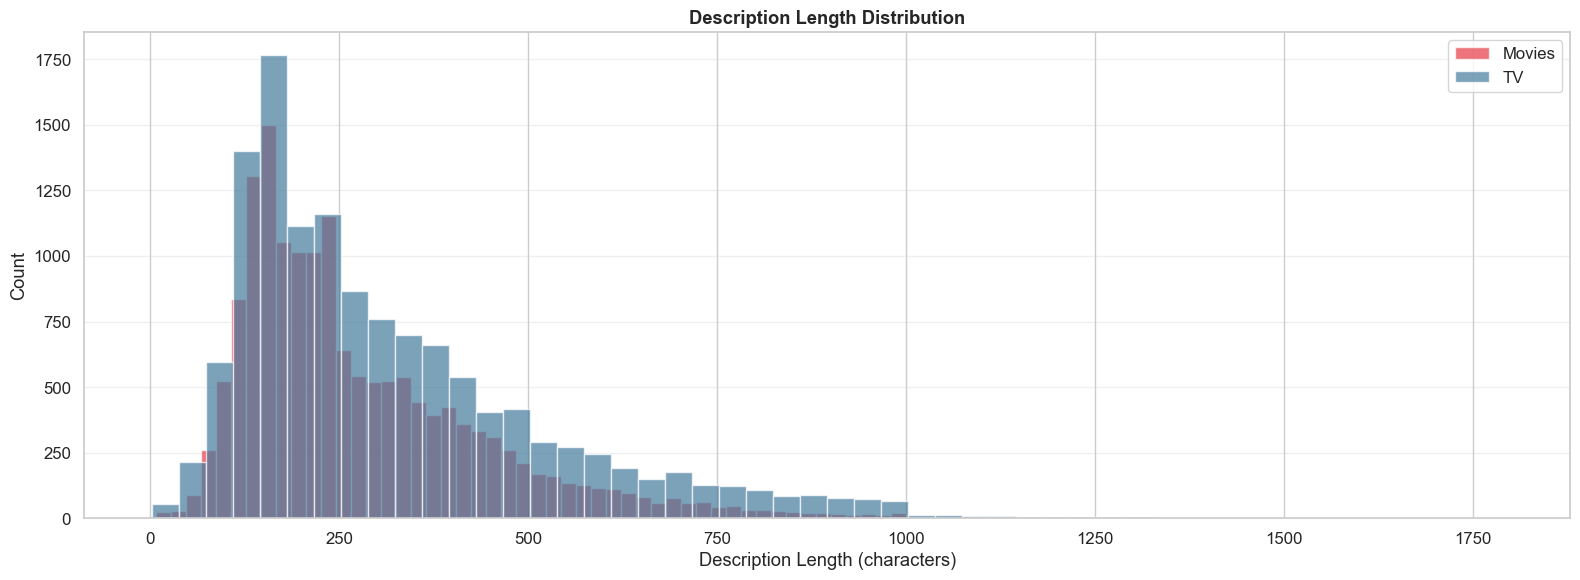

In [50]:
# Description length distribution
df_movies['desc_len'] = df_movies['description'].dropna().apply(len)
df_tv['desc_len'] = df_tv['description'].dropna().apply(len)

print("Description Length (characters)")
print(f"Movies: mean={df_movies['desc_len'].mean():.0f}, "
      f"min={df_movies['desc_len'].min():.0f}, max={df_movies['desc_len'].max():.0f}")
print(f"TV:     mean={df_tv['desc_len'].mean():.0f}, "
      f"min={df_tv['desc_len'].min():.0f}, max={df_tv['desc_len'].max():.0f}")
print("\nDescription example: ")
print(df_movies['description'][:5].to_list())

fig, ax = plt.subplots(figsize=(16, 6))
ax.hist(df_movies['desc_len'].dropna(), bins=50, alpha=0.7, color='#E63946', label='Movies')
ax.hist(df_tv['desc_len'].dropna(), bins=50, alpha=0.7, color='#457B9D', label='TV')
ax.set_xlabel('Description Length (characters)')
ax.set_ylabel('Count')
ax.set_title('Description Length Distribution', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
# Release year distribution — is the data balanced over time?
print("Content per year")
print("Movies:\n", df_movies['release_year'].value_counts().sort_index())
print("\nTV:\n", df_tv['release_year'].value_counts().sort_index())

Content per year
Movies:
 release_year
2010    1000
2011    1000
2012    1000
2013    1000
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
2023    1000
2024    1000
2025    1000
Name: count, dtype: int64

TV:
 release_year
2010    1000
2011    1000
2012    1000
2013    1000
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
2023    1000
2024    1000
2025    1000
Name: count, dtype: int64


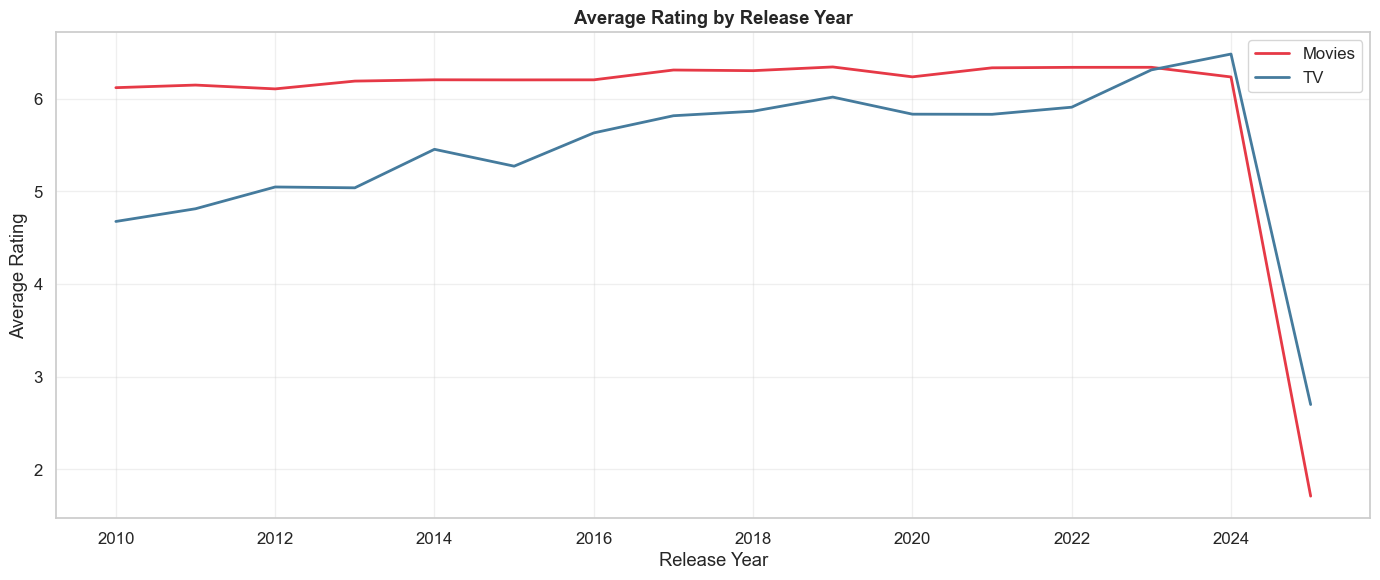

In [34]:
movie_avg_rating = df_movies.groupby('release_year')['rating'].mean()
tv_avg_rating = df_tv.groupby('release_year')['rating'].mean()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(movie_avg_rating.index, movie_avg_rating.values, color='#E63946', label='Movies', linewidth=2)
ax.plot(tv_avg_rating.index, tv_avg_rating.values, color='#457B9D', label='TV', linewidth=2)
ax.set_xlabel('Release Year')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating by Release Year', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
df_movies

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue,desc_len
0,10192,Movie,Shrek Forever After,Mike Mitchell,"Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...",United States of America,2010-05-16,2010,6.380,NaN,"Comedy, Adventure, Fantasy, Animation, Family",en,A bored and domesticated Shrek pacts with deal...,203.893,7449,6.380,165000000,752600867,322.0
1,27205,Movie,Inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","United Kingdom, United States of America",2010-07-15,2010,8.369,NaN,"Action, Science Fiction, Adventure",en,"Cobb, a skilled thief who commits corporate es...",156.242,37119,8.369,160000000,839030630,280.0
2,12444,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...","United Kingdom, United States of America",2010-11-17,2010,7.744,NaN,"Adventure, Fantasy",en,"Harry, Ron and Hermione walk away from their l...",121.191,19327,7.744,250000000,954305868,298.0
3,38757,Movie,Tangled,"Byron Howard, Nathan Greno","Mandy Moore, Zachary Levi, Donna Murphy, Ron P...",United States of America,2010-11-24,2010,7.600,NaN,"Animation, Family, Adventure",en,"Feisty teenager Rapunzel, who has long and mag...",111.762,11638,7.600,260000000,592461732,286.0
4,10191,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois","Jay Baruchel, Gerard Butler, Craig Ferguson, A...",United States of America,2010-03-18,2010,7.800,NaN,"Fantasy, Adventure, Animation, Family",en,As the son of a Viking leader on the cusp of m...,110.044,13259,7.800,165000000,494879471,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,1440286,Movie,Festival de Viña del Mar 2025: Ha*Ash,NaN,Ha*ash,Chile,2025-02-24,2025,0.000,NaN,Music,es,NaN,4.931,0,0.000,0,0,NaN
15996,1271724,Movie,Man and Woman,Vladimir Kott,"Anna Kotova, Stepan Devonin, Pavel Derevyanko,...",Russia,2025-03-13,2025,0.000,NaN,Drama,ru,Poignant stories about men and women who have ...,4.930,0,0.000,0,0,404.0
15997,1426364,Movie,Night of the Dead Sorority Babes,"Angel Nichole Bradford, Steve Hermann","Jessa Flux, Lynn Lowry, Angel Nichole Bradford...",NaN,2025-01-28,2025,1.000,NaN,Horror,en,Two villainous entities initiate gorgeous soro...,4.922,1,1.000,0,0,208.0
15998,1411248,Movie,A Dunces Burden,Daniel Kowal,"Riley G, Mitchel Corrado",NaN,2025-03-10,2025,0.000,NaN,NaN,en,A Dunces Burden,4.921,0,0.000,0,0,15.0
